In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['HW8D60SUPB15_VOL_1.xls',
                  'HW8D60SUPB15_VOL_2.xls',
                  'HW8D60SUPB15_VOL_3.xls',
                  'BCRABL_PDX_1_MAP2.xls',
                  'BCRABL_PDX_2_MAP2.xls', 
                  'BCRABL_PDX_3_MAP2.xls',
                  'LAX7_1_MAP2.xls',
                  'LAX7_2_MAP2.xls', 
                  'LAX7_3_MAP2.xls',
                  'LAX7R_1_MAP2.xls',
                  'LAX7R_2_MAP2.xls',
                  'LAX7R_3_MAP2.xls',
                  'VOL_1857_1.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_3.xls',
                  '697_1_MAP2.xls',
                  '697_2_MAP2.xls', 
                  '697_3_MAP2.xls',
                  'BCELL_1_MAP2.xls',
                  'BCELL_2_MAP2.xls', 
                  'BCELL_3_MAP2.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['HW8D60SUPB15_DOTS_1.xls',
                'HW8D60SUPB15_DOTS_2.xls',
                'HW8D60SUPB15_DOTS_3.xls',
                'BCRABL_PDX_1_CFSE.xls',
                'BCRABL_PDX_2_CFSE.xls', 
                'BCRABL_PDX_3_CFSE.xls',
                'LAX7_1_CFSE.xls',
                'LAX7_2_CFSE.xls', 
                'LAX7_3_CFSE.xls',
                'LAX7R_1_CFSE.xls',
                'LAX7R_2_CFSE.xls',
                'LAX7R_3_CFSE.xls',
                'DOTS_1857_1.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_3.xls',
                '697_1_CFSE.xls',
                '697_2_CFSE.xls', 
                '697_3_CFSE.xls',
                'BCELL_1_CFSE.xls',
                'BCELL_2_CFSE.xls', 
                'BCELL_3_CFSE.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 13962 / 10444
[Open3D DEBUG] #   Got kernel density: 0.00300789 (s), 392.309 (MB) / 392.309 (MB) / 392 (MB)
[Open3D DEBUG] #     Got normal field: 0.0330651 (s), 394.922 (MB) / 394.922 (MB) / 394 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.427893e-06 / 3.389824e-02
[Open3D DEBUG] #       Finalized tree: 0.0316379 (s), 397.207 (MB) / 397.207 (MB) / 397 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.049592 (s), 397.352 (MB) / 397.352 (MB) / 397 (MB)
[Open3D DEBUG] #Set point constraints: 0.00910282 (s), 398.141 (MB) / 398.141 (MB) / 398 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 197023 / 216952 / 8217
[Open3D DEBUG] Memory Usage: 398.141 MB
[Open3D DEBUG] # Linear system solved: 0.186543 (s), 399.414 (MB) / 399.414 (MB) / 399 (MB)
[Open3D DEBUG] Got average: 0.00403690 (s), 399.867 (MB) / 399.867 (MB) / 399 (MB)
[Open3D DEBUG] Iso-Value: 5.170907e-01 = 7.219621e+03 / 1.396200e+04
[Open3D DEBUG] #          Total Solve:      

[Open3D DEBUG] #   Got kernel density: 0.00383687 (s), 456.852 (MB) / 456.852 (MB) / 456 (MB)
[Open3D DEBUG] #     Got normal field: 0.0261171 (s), 456.852 (MB) / 456.852 (MB) / 456 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.974118e-07 / 1.963986e-02
[Open3D DEBUG] #       Finalized tree: 0.0275311 (s), 456.883 (MB) / 456.883 (MB) / 456 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0428519 (s), 457.602 (MB) / 457.602 (MB) / 457 (MB)
[Open3D DEBUG] #Set point constraints: 0.00439906 (s), 458.371 (MB) / 458.371 (MB) / 458 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 166174 / 187640 / 2273
[Open3D DEBUG] Memory Usage: 458.371 MB
[Open3D DEBUG] # Linear system solved: 0.140293 (s), 462.086 (MB) / 462.086 (MB) / 462 (MB)
[Open3D DEBUG] Got average: 0.00341821 (s), 462.453 (MB) / 462.453 (MB) / 462 (MB)
[Open3D DEBUG] Iso-Value: 5.149506e-01 = 1.126969e+04 / 2.188500e+04
[Open3D DEBUG] #          Total Solve:       1.1 (s),     473.5 (MB)
[Open3D WARNING] Ignoring a

[Open3D DEBUG] #          Total Solve:       1.0 (s),     601.2 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 26326 / 18468
[Open3D DEBUG] #   Got kernel density: 0.00328994 (s), 598.18 (MB) / 601.219 (MB) / 601 (MB)
[Open3D DEBUG] #     Got normal field: 0.0410020 (s), 598.18 (MB) / 601.219 (MB) / 601 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.110627e-06 / 2.923836e-02
[Open3D DEBUG] #       Finalized tree: 0.0391040 (s), 599.488 (MB) / 601.219 (MB) / 601 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0520461 (s), 599.488 (MB) / 601.219 (MB) / 601 (MB)
[Open3D DEBUG] #Set point constraints: 0.00516295 (s), 599.488 (MB) / 601.219 (MB) / 601 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 218695 / 248328 / 1609
[Open3D DEBUG] Memory Usage: 599.488 MB
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(458.371 MB)	Nodes: 8
CG: 7.3564e-03 ->

[Open3D DEBUG] #       Finalized tree: 0.0278671 (s), 609.148 (MB) / 609.148 (MB) / 609 (MB)in:  0.003 /  0.008 /  0.014	(593.816 MB)	Nodes: 48056
                  GS: 1.2598e-01 -> 1.2598e-01 -> 8.8854e-04 (7.1e-03) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.017 /  0.029	(593.816 MB)	Nodes: 105160
                    GS: 6.9033e-02 -> 6.9033e-02 -> 1.9650e-04 (2.8e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(599.480 MB)	Nodes: 8
CG: 9.2622e-03 -> 9.2622e-03 -> 3.4464e-06 (3.7e-04) [32653]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(599.480 MB)	Nodes: 27
  GS: 4.7741e-02 -> 4.7741e-02 -> 5.0762e-04 (1.1e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(599.480 MB)	Nodes: 125
    GS: 7.3830e-02 -> 7.3830e-02 -> 1.2679e-03 (1.7e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got

Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.012 /  0.012	(599.488 MB)	Nodes: 3[Open3D DEBUG] # Linear system solved: 0.107615 (s), 610.422 (MB) / 618.43 (MB) / 618 (MB)
[Open3D DEBUG] Got average: 0.00234509 (s), 610.422 (MB) / 618.43 (MB) / 618 (MB)
[Open3D DEBUG] Iso-Value: 5.021666e-01 = 2.236650e+03 / 4.454000e+03
5937
          GS: 2.5515e-01 -> 2.5515e-01 -> 2.8657e-03 (1.1e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(599.488 MB)	Nodes: 2928
            GS: 2.4041e-01 -> 2.4041e-01 -> 1.0958e-03 (4.6e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(599.488 MB)	Nodes: 5992
              GS: 2.4964e-01 -> 2.4964e-01 -> 1.1193e-03 (4.5e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.007	(599.488 MB)	Nodes: 16280
                GS: 1.9941e-01 -> 1.9941e-01 -> 1.0304e-03 (5.2e-03) [8]



        GS: 2.3785e-01 -> 2.3785e-01 -> 4.7169e-03 (2.0e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.012 /  0.010	(614.320 MB)	Nodes: 35937
          GS: 2.4349e-01 -> 2.4349e-01 -> 2.9691e-03 (1.2e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.001	(614.320 MB)	Nodes: 2928
            GS: 2.4381e-01 -> 2.4381e-01 -> 4.5388e-04 (1.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(614.320 MB)	Nodes: 4968
              GS: 2.0553e-01 -> 2.0553e-01 -> 9.4056e-04 (4.6e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.005	(614.320 MB)	Nodes: 13840
                GS: 1.7723e-01 -> 1.7723e-01 -> 1.2177e-03 (6.9e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.009 /  0.013	(614.320 MB)	Nodes: 46256
                  GS: 1.1642e-01 -> 1.1642e-01 -> 1.1063

[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.IsoSurface.specialized.inl (Line 1858)
          Extract
          bad average roots: 3


[Open3D DEBUG] #       Finalized tree: 0.039638 (s), 612.156 (MB) / 618.43 (MB) / 618 (MB)9
      GS: 1.1781e-01 -> 1.1781e-01 -> 2.8401e-03 (2.4e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(610.422 MB)	Nodes: 4913
        GS: 1.5989e-01 -> 1.5989e-01 -> 3.1417e-03 (2.0e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.012 /  0.012	(610.422 MB)	Nodes: 35937
          GS: 1.6598e-01 -> 1.6598e-01 -> 1.7216e-03 (1.0e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(610.422 MB)	Nodes: 2728
            GS: 1.6028e-01 -> 1.6028e-01 -> 4.5974e-04 (2.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(610.422 MB)	Nodes: 4080
              GS: 1.4887e-01 -> 1.4887e-01 -> 4.6233e-04 (3.1e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.005	(6

[Open3D DEBUG] # Linear system solved: 0.175861 (s), 647.934 (MB) / 647.934 (MB) / 647 (MB)
[Open3D DEBUG] Got average: 0.00529909 (s), 647.934 (MB) / 647.934 (MB) / 647 (MB)
[Open3D DEBUG] Iso-Value: 5.126396e-01 = 2.844176e+04 / 5.548100e+04
[Open3D DEBUG] #          Total Solve:       1.3 (s),     653.1 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 1791 / 1366
[Open3D DEBUG] #   Got kernel density: 0.00115800 (s), 653.121 (MB) / 653.121 (MB) / 653 (MB)
[Open3D DEBUG] #     Got normal field: 0.00430799 (s), 653.121 (MB) / 653.121 (MB) / 653 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.104670e-05 / 1.978464e-02
[Open3D DEBUG] #       Finalized tree: 0.015856 (s), 653.121 (MB) / 653.121 (MB) / 653 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.031776 (s), 653.121 (MB) / 653.121 (MB) / 653 (MB)
[Open3D DEBUG] #Set point constraints: 0.00173593 (s), 653.121 (MB) / 653.121 (MB) / 653 (MB)
[Open3D D

Cycle[0] Depth[[Open3D DEBUG] Input Points / Samples: 27203 / 2403410/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.006	(621.082 MB)	Nodes: 0
                    GS: 0.0000e+00 -> 0.0000e+00 -> 0.0000e+00 (nan) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(647.934 MB)	Nodes: 8
CG: 1.1258e-02 -> 1.1258e-02 -> 2.2824e-06 (2.0e-04) [32653]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(647.934 MB)	Nodes: 27
  GS: 7.5887e-02 -> 7.5887e-02 -> 1.1921e-03 (1.6e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(647.934 MB)	Nodes: 125
    GS: 1.1450e-01 -> 1.1450e-01 -> 2.8586e-03 (2.5e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(647.934 MB)	Nodes: 729
      GS: 1.9065e-01 -> 1.9065e-01 -> 4.4201e-03 (2.3e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / G

[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.IsoSurface.specialized.inl (Line 1858)
          Extract
          bad average roots: 3


[Open3D DEBUG] #          Total Solve:       1.0 (s),     698.8 (MB)10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.000	(696.504 MB)	Nodes: 729
      GS: 2.0561e-01 -> 2.0561e-01 -> 5.8109e-03 (2.8e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(696.504 MB)	Nodes: 4913
        GS: 2.6624e-01 -> 2.6624e-01 -> 5.1970e-03 (2.0e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.015 /  0.016	(696.504 MB)	Nodes: 35937
          GS: 2.5655e-01 -> 2.5655e-01 -> 2.7164e-03 (1.1e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(696.504 MB)	Nodes: 2992
            GS: 2.4470e-01 -> 2.4470e-01 -> 1.1465e-03 (4.7e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(696.504 MB)	Nodes: 6208
              GS: 2.0315e-01 -> 2.0315e-01 -> 8.9238e-04 (4.4e-03) [8]
Cycle[0] Depth[ 8/10

[Open3D DEBUG] #          Total Solve:       1.2 (s),     754.3 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 21474 / 18741
[Open3D DEBUG] #   Got kernel density: 0.00443292 (s), 747.262 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] #     Got normal field: 0.0563281 (s), 747.262 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.846969e-06 / 3.966181e-02
[Open3D DEBUG] #       Finalized tree: 0.0575521 (s), 747.262 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0602670 (s), 747.262 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] #Set point constraints: 0.00639415 (s), 747.262 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 262410 / 295640 / 4257
[Open3D DEBUG] Memory Usage: 747.262 MB
[Open3D DEBUG] # Linear system solved: 0.237197 (s), 747.758 (MB) / 754.285 (MB) / 754 (MB)
[Open3D DEBUG] Got average: 0.00407505 

:	Updated constraints / Got system / Solved in:  0.004 /  0.036 /  0.103	(714.336 MB)	Nodes: 143616
                    GS: 5.9100e-02 -> 5.9100e-02 -> 3.8895e-04 (6.6e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(722.016 MB)	Nodes: 8
CG: 6.5033e-03 -> 6.5033e-03 -> 7.2664e-08 (1.1e-05) [32653]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(722.016 MB)	Nodes: 27
  GS: 4.8519e-02 -> 4.8519e-02 -> 4.9060e-04 (1.0e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(722.016 MB)	Nodes: 125
    GS: 7.4485e-02 -> 7.4485e-02 -> 1.2347e-03 (1.7e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(722.016 MB)	Nodes: 729
      GS: 1.2624e-01 -> 1.2624e-01 -> 2.1045e-03 (1.7e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.004 /  0.002	(722.023 MB)	Nod

      GS: 2.2192e-01 -> 2.2192e-01 -> 5.9095e-03 (2.7e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(747.758 MB)	Nodes: 4913
        GS: 2.9025e-01 -> 2.9025e-01 -> 5.3453e-03 (1.8e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.010 /  0.016	(747.758 MB)	Nodes: 35937
          GS: 2.7932e-01 -> 2.7932e-01 -> 2.7049e-03 (9.7e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.002 /  0.002	(747.758 MB)	Nodes: 2928
            GS: 2.5548e-01 -> 2.5548e-01 -> 1.2550e-03 (4.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.002	(747.758 MB)	Nodes: 6208
              GS: 2.3259e-01 -> 2.3259e-01 -> 9.1229e-04 (3.9e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.004 /  0.010	(747.758 MB)	Nodes: 16504
                GS: 1.7775e-01 -> 1.7775e-01 -> 2.0041e-03 (1.1e-02)

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

Entity  Distance to Surface (μm)
0          A                  1.885051
1          A                  2.056081
2          A                  0.900723
3          A                  0.245485
4          A                  0.137147
...      ...                       ...
84604      U                       NaN
84605      U                       NaN
84606      U                       NaN
84607      U                       NaN
84608      U                       NaN

[84609 rows x 2 columns]

In [25]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'
df.loc[df['Entity'] == 'G', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'H', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'I', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'J', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'K', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'L', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'M', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'N', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'O', 'Types'] = 'Repeat 3'
df.loc[df['Entity'] == 'P', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'Q', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'R', 'Types'] = 'Repeat 3'
df.loc[df['Entity'] == 'S', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'T', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'U', 'Types'] = 'Repeat 3'

df['Entity'] = df['Entity'].replace({
              'A':'BCRABL',
              'B':'BCRABL',
              'C':'BCRABL',
              'D':'PDX2',
              'E':'PDX2',
              'F':'PDX2',
              'G':'Initial',
              'H':'Initial',
              'I':'Initial',
              'J':'Relapse',
              'K':'Relapse',
              'L':'Relapse',
              'M':'PDX',
              'N':'PDX',
              'O':'PDX',
              'P':'697',
              'Q':'697',
              'R':'697',
              'S':'BLYMPHOCYTE',
              'T':'BLYMPHOCYTE',
              'U':'BLYMPHOCYTE'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

#df_filtered below filters for measurements above 10μm
df_filtered = df_final[df_final['Distance to Surface (μm)'] >10]
df_filtered.to_excel("df_filtered.xlsx", sheet_name='filtered')
display(df_filtered)

#Below are lines of code to extract the number of values for each 'Entity' given as "count of values for each entity"
entity_counts = df_filtered['Entity'].value_counts()

# Print the results
print("Count of values for each entity:")
print(entity_counts)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_type_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Print the results
print("Count of values for each entity and replicate:")
print(entity_type_counts)

Entity  Distance to Surface (μm)     Types
0           BCRABL                  1.885051  Repeat 1
1           BCRABL                  2.056081  Repeat 1
2           BCRABL                  0.900723  Repeat 1
3           BCRABL                  0.245485  Repeat 1
4           BCRABL                  0.137147  Repeat 1
...            ...                       ...       ...
81503  BLYMPHOCYTE                  4.822407  Repeat 3
81504  BLYMPHOCYTE                  7.199219  Repeat 3
81505  BLYMPHOCYTE                  3.627583  Repeat 3
81506  BLYMPHOCYTE                  0.760324  Repeat 3
81507  BLYMPHOCYTE                 23.748123  Repeat 3

[27945 rows x 3 columns]

Entity  Distance to Surface (μm)     Types
22          BCRABL                 19.032181  Repeat 1
23          BCRABL                 19.351938  Repeat 1
24          BCRABL                 12.655099  Repeat 1
25          BCRABL                 25.445148  Repeat 1
26          BCRABL                 13.022331  Repeat 1
...            ...                       ...       ...
81438  BLYMPHOCYTE                 19.889431  Repeat 3
81478  BLYMPHOCYTE                 12.534343  Repeat 3
81480  BLYMPHOCYTE                 38.622421  Repeat 3
81494  BLYMPHOCYTE                 98.213760  Repeat 3
81507  BLYMPHOCYTE                 23.748123  Repeat 3

[1861 rows x 3 columns]

Count of values for each entity:
PDX            709
697            328
BCRABL         272
BLYMPHOCYTE    216
PDX2           163
Initial        124
Relapse         49
Name: Entity, dtype: int64
Count of values for each entity and replicate:
         Entity     Types  Count
0           697  Repeat 1     76
1           697  Repeat 2    192
2           697  Repeat 3     60
3        BCRABL  Repeat 1    157
4        BCRABL  Repeat 2     43
5        BCRABL  Repeat 3     72
6   BLYMPHOCYTE  Repeat 1     44
7   BLYMPHOCYTE  Repeat 2    102
8   BLYMPHOCYTE  Repeat 3     70
9       Initial  Repeat 1     26
10      Initial  Repeat 2     46
11      Initial  Repeat 3     52
12          PDX  Repeat 1    306
13          PDX  Repeat 2    234
14          PDX  Repeat 3    169
15         PDX2  Repeat 1     28
16         PDX2  Repeat 2     65
17         PDX2  Repeat 3     70
18      Relapse  Repeat 1      4
19      Relapse  Repeat 2     26
20      Relapse  Repeat 3     19


In [8]:
#This is optional to change any names as above
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'Leukemia Replicate 1',
                   'E': 'Leukemia Replicate 2',
                   'F': 'Leukemia Replicate 3',
                   'G': 'Leukemia Replicate 1',
                   'H': 'Leukemia Replicate 2',
                   'I': 'Leukemia Replicate 3',
                   'J': 'Leukemia Replicate 1',
                   'K': 'Leukemia Replicate 2',
                   'L': 'Leukemia Replicate 3',
                   'M': 'Leukemia Replicate 1',
                   'N': 'Leukemia Replicate 2',
                   'O': 'Leukemia Replicate 3',
                   'P': 'Leukemia Replicate 1',
                   'Q': 'Leukemia Replicate 2',
                   'R': 'Leukemia Replicate 3',
                   'S': 'B Lymphocyte Replicate 1',
                   'T': 'B Lymphocyte Replicate 2',
                   'U': 'B Lymphocyte Replicate 3'}, inplace=True)

#df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
#df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_15245/387141741.py:25: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


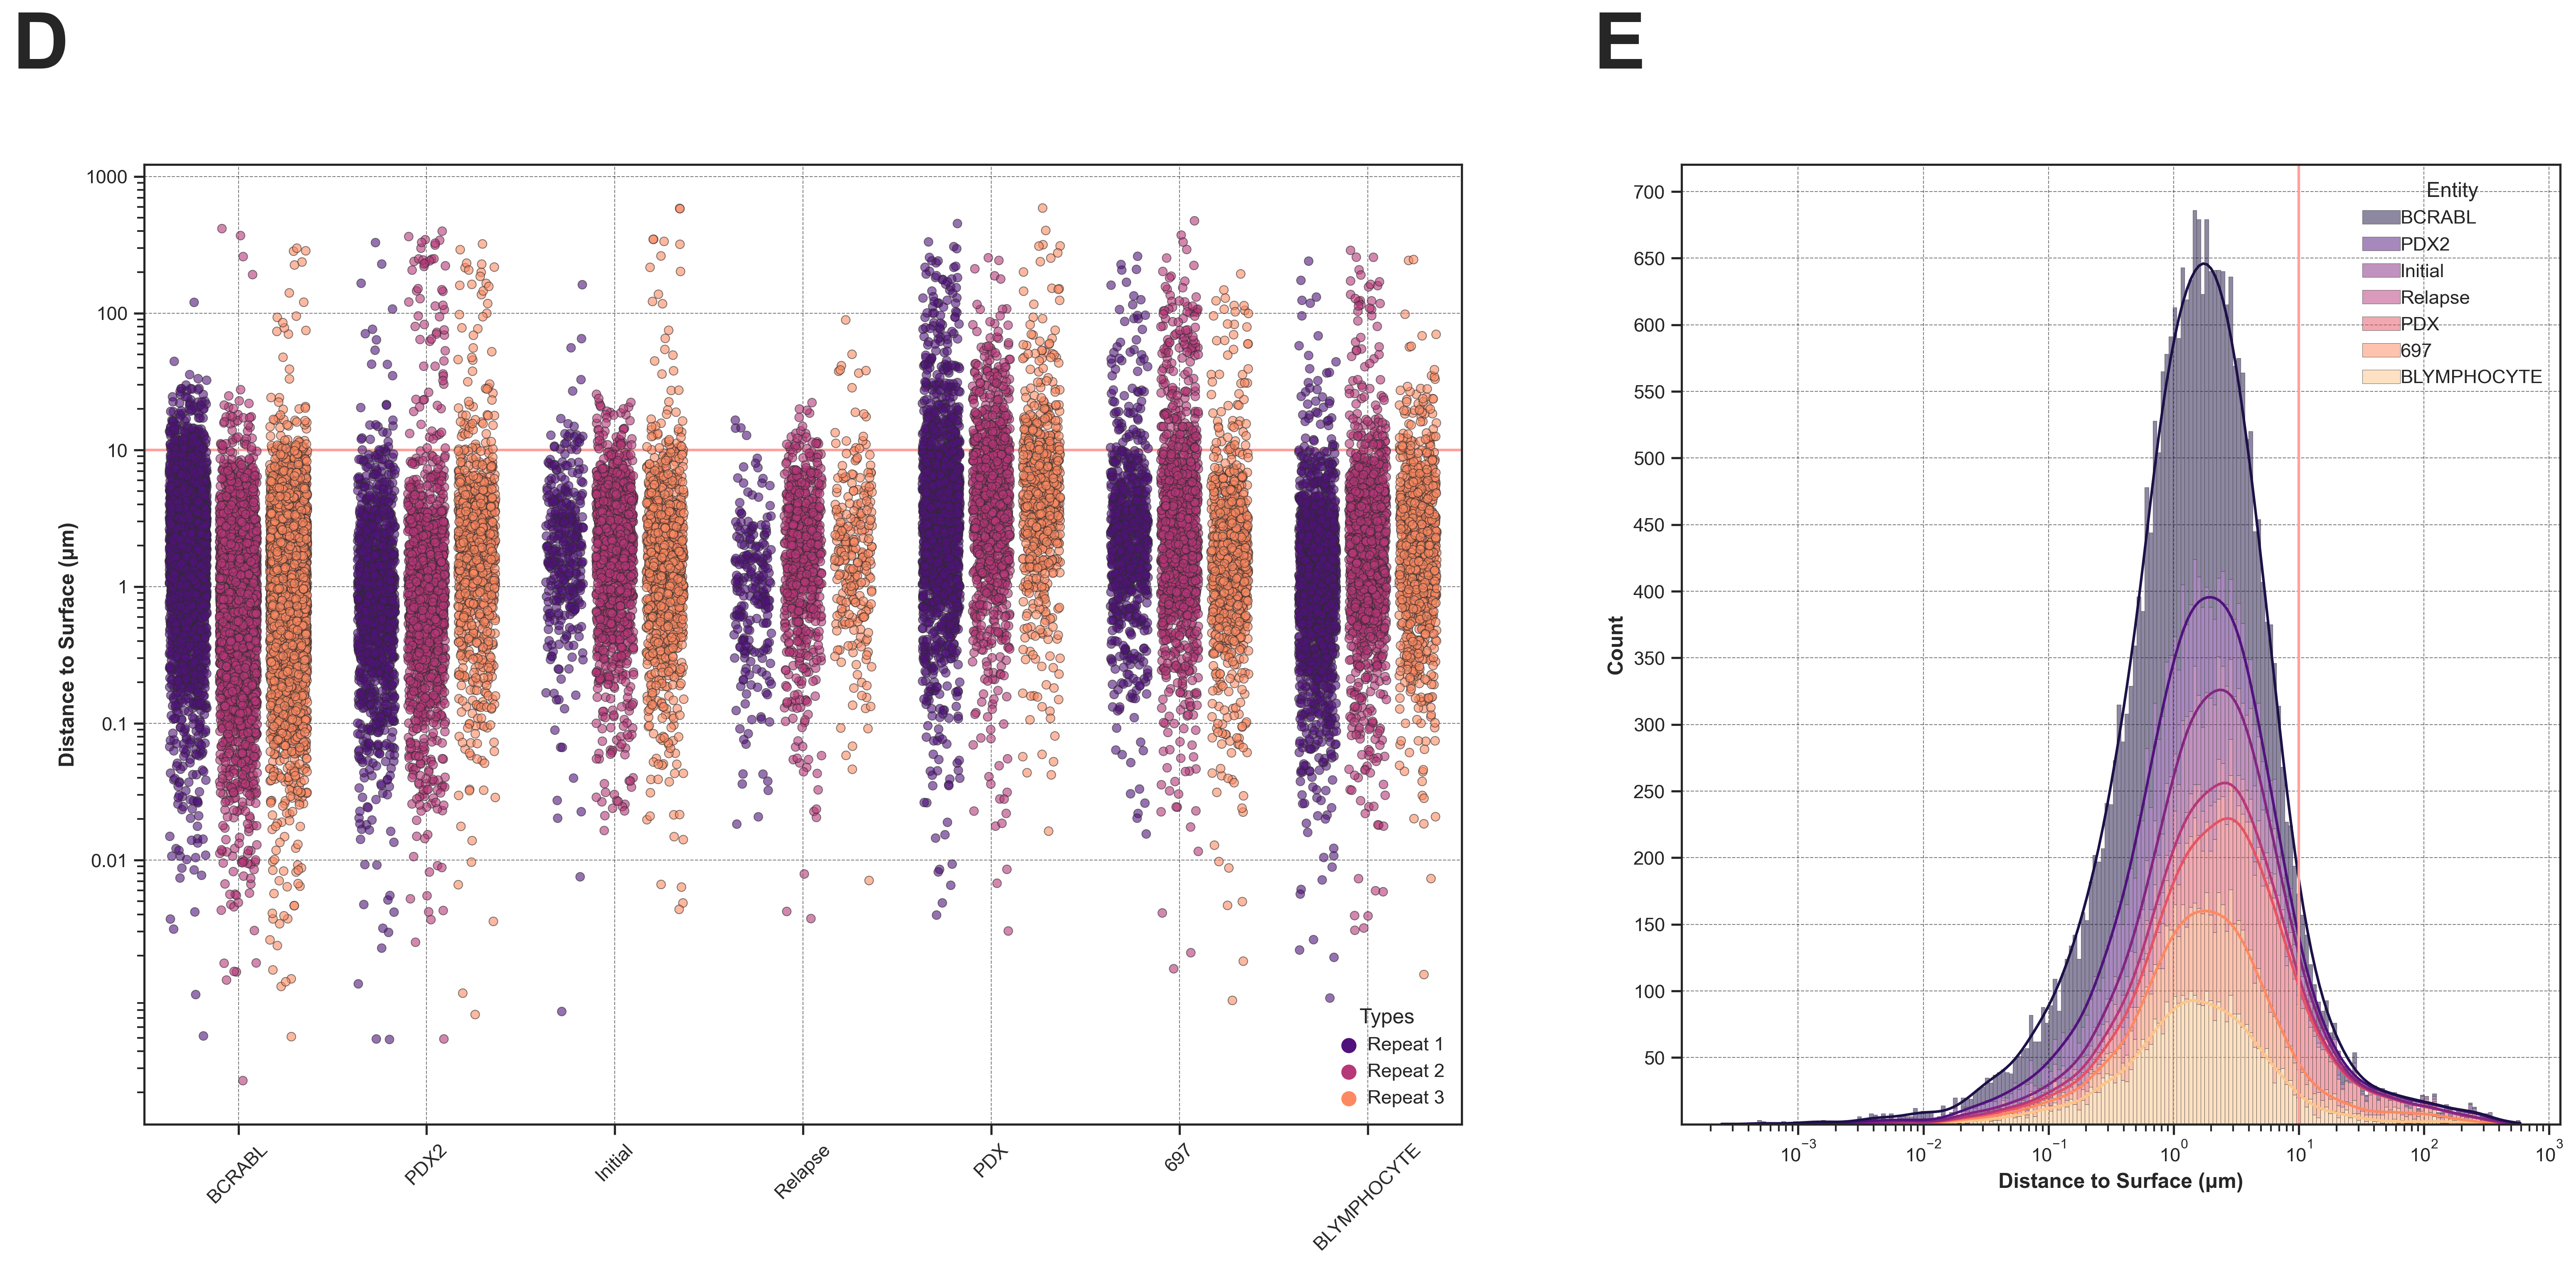

In [11]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [3, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="magma", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="magma",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=True,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

texts = ['D', 'E']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('All_Leukemia_vs_Healthy.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('All_Leukemia_vs_Healthy.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
# Visualization and image export
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False)  # works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(f'mesh_{index}.png', do_render=True)
#vis.destroy_window()

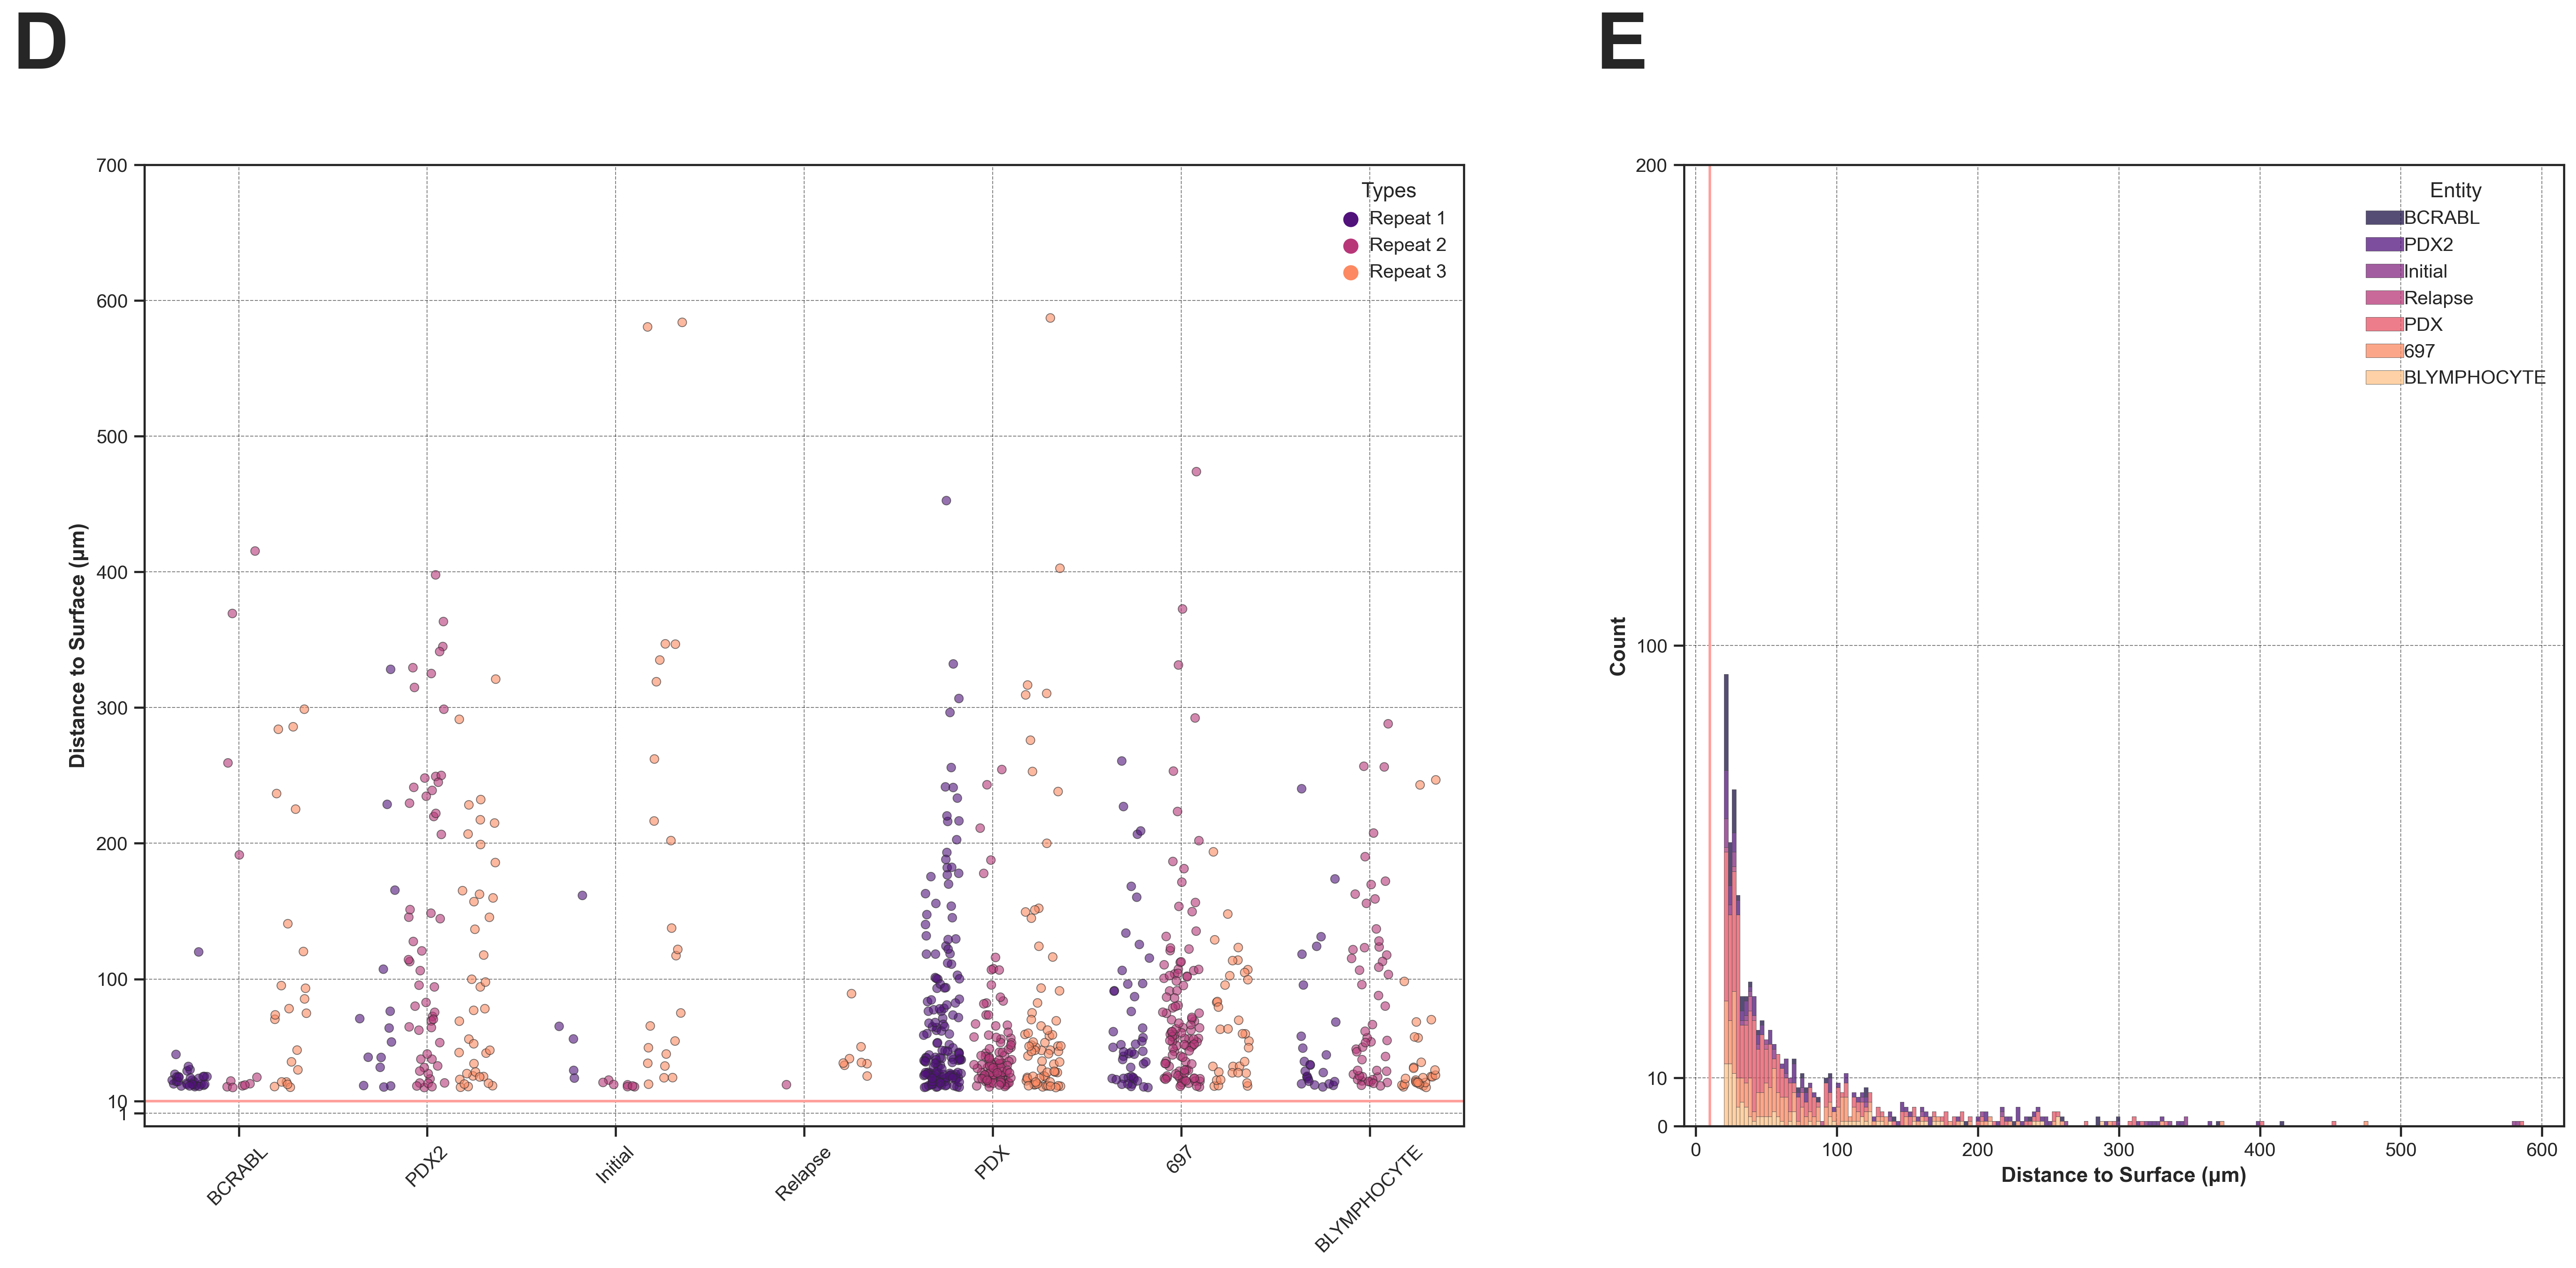

In [24]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [3, 2]})
g = sns.stripplot(ax=axes[0], data=df_filtered,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="magma", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
#g.set_yscale("log")
# the non-logarithmic labels
ticks = [1, 10, 100, 200, 300, 400, 500, 600, 700]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_filtered,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="magma",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=False,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [0, 10, 100, 200]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

texts = ['D', 'E']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

#plt.savefig(plot_savepath('All_Leukemia_vs_Healthy.pdf'), bbox_inches='tight')
#plt.savefig(plot_savepath('All_Leukemia_vs_Healthy.png'), dpi=300, bbox_inches='tight')

plt.show()